In [43]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
# 1. Load expression data
expr = pd.read_csv("brca_metabric/data_mrna_illumina_microarray.txt", sep="\t")

In [14]:
expr.head()

,Hugo_Symbol,Entrez_Gene_Id,MB-0362,MB-0346,MB-0386,MB-0574,MB-0185,MB-0503,MB-0641,MB-0201,...,MB-6192,MB-4820,MB-5527,MB-5167,MB-5465,MB-5453,MB-5471,MB-5127,MB-4313,MB-4823
0,RERE,473,8.676978,9.653589,9.033589,8.814855,8.736406,9.274265,9.286585,8.437347,...,8.804947,9.991215,9.595923,9.637249,8.131637,9.606915,9.049296,8.858622,8.415867,9.902776
1,RNF165,494470,6.075331,6.687887,5.910885,5.628740,6.392422,5.908698,6.206729,6.095592,...,5.601472,7.103160,6.418987,6.203370,9.101942,7.427494,6.850000,6.550450,6.831722,7.338318
2,PHF7,51533,5.838270,5.600876,6.030718,5.849428,5.542133,5.964661,5.783374,5.737572,...,5.922894,6.181493,5.992153,6.230316,5.644587,5.927409,6.117095,5.936371,7.408960,5.875759
3,CIDEA,1149,6.397503,5.246319,10.111816,6.116868,5.184098,7.828171,8.744149,5.480091,...,6.488136,5.612846,6.241160,5.560488,5.611189,5.927031,6.374305,5.963092,9.181768,5.596873
4,TENT2,167153,7.906217,8.267256,7.959291,9.206376,8.162845,8.706646,8.518929,7.478413,...,8.534527,8.203819,8.813103,8.612911,7.798269,8.520545,8.499637,9.320207,6.804085,8.436732


In [15]:
# Keep only Hugo_Symbol and Entrez_Gene_Id
if 'Entrez_Gene_Id' in expr.columns:
    expr = expr.drop(columns=['Entrez_Gene_Id'])

In [16]:
expr.head()

,Hugo_Symbol,MB-0362,MB-0346,MB-0386,MB-0574,MB-0185,MB-0503,MB-0641,MB-0201,MB-0218,...,MB-6192,MB-4820,MB-5527,MB-5167,MB-5465,MB-5453,MB-5471,MB-5127,MB-4313,MB-4823
0,RERE,8.676978,9.653589,9.033589,8.814855,8.736406,9.274265,9.286585,8.437347,8.569973,...,8.804947,9.991215,9.595923,9.637249,8.131637,9.606915,9.049296,8.858622,8.415867,9.902776
1,RNF165,6.075331,6.687887,5.910885,5.628740,6.392422,5.908698,6.206729,6.095592,6.383530,...,5.601472,7.103160,6.418987,6.203370,9.101942,7.427494,6.850000,6.550450,6.831722,7.338318
2,PHF7,5.838270,5.600876,6.030718,5.849428,5.542133,5.964661,5.783374,5.737572,5.923928,...,5.922894,6.181493,5.992153,6.230316,5.644587,5.927409,6.117095,5.936371,7.408960,5.875759
3,CIDEA,6.397503,5.246319,10.111816,6.116868,5.184098,7.828171,8.744149,5.480091,5.671577,...,6.488136,5.612846,6.241160,5.560488,5.611189,5.927031,6.374305,5.963092,9.181768,5.596873
4,TENT2,7.906217,8.267256,7.959291,9.206376,8.162845,8.706646,8.518929,7.478413,8.410583,...,8.534527,8.203819,8.813103,8.612911,7.798269,8.520545,8.499637,9.320207,6.804085,8.436732


In [17]:
# Transpose gene expression: rows = samples, columns = genes
expr = expr.set_index('Hugo_Symbol').T
expr.index.name = 'SAMPLE_ID'
expr.reset_index(inplace=True)

In [18]:
expr

Hugo_Symbol,SAMPLE_ID,RERE,RNF165,PHF7,CIDEA,TENT2,SLC17A3,SDS,ATP6V1C2,F3,...,SBF2-AS1,VN1R4,TRPV5,UGGT1,CR590356,VPS72,CSMD3,CC2D1A,IGSF9,FAM71A
0,MB-0362,8.676978,6.075331,5.838270,6.397503,7.906217,5.702379,6.930741,5.332863,5.275676,...,5.335488,5.309543,5.449278,7.688492,5.783457,8.084979,5.161796,6.353215,7.304643,5.049591
1,MB-0346,9.653589,6.687887,5.600876,5.246319,8.267256,5.521794,6.141689,7.563477,5.376381,...,5.471839,5.579198,5.657015,7.804165,6.487002,8.349115,5.197392,6.132355,7.933324,5.316790
2,MB-0386,9.033589,5.910885,6.030718,10.111816,7.959291,5.689533,6.529312,5.482155,5.463788,...,5.322604,5.484665,5.556244,7.934309,6.011908,8.406332,8.087722,6.366335,7.580336,5.461617
3,MB-0574,8.814855,5.628740,5.849428,6.116868,9.206376,5.439130,6.430102,5.398675,5.409761,...,5.520733,5.419803,5.450339,7.744562,6.032705,8.310019,5.780062,6.424048,6.903654,5.227130
4,MB-0185,8.736406,6.392422,5.542133,5.184098,8.162845,5.464326,6.105427,5.026018,5.338580,...,5.542151,5.340978,5.616935,7.613439,5.678840,8.161977,5.327687,6.252966,6.848395,5.057761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1975,MB-5453,9.606915,7.427494,5.927409,5.927031,8.520545,5.550549,5.841476,5.832439,7.180979,...,5.199192,5.153886,5.535933,7.048923,6.231014,7.560101,5.397010,7.088676,7.248336,5.436415
1976,MB-5471,9.049296,6.850000,6.117095,6.374305,8.499637,5.497546,6.351428,5.544773,5.919886,...,5.377531,5.434900,5.454926,7.733413,6.154021,7.941895,5.415928,6.110477,7.596215,5.094339
1977,MB-5127,8.858622,6.550450,5.936371,5.963092,9.320207,5.690297,7.280037,5.171260,5.937993,...,5.267150,5.488637,5.630339,7.311774,5.983834,7.866579,5.242482,6.316304,6.620605,5.350708
1978,MB-4313,8.415867,6.831722,7.408960,9.181768,6.804085,5.730308,7.642485,5.900949,6.019427,...,6.264994,5.506242,5.570980,9.652446,7.511728,7.752503,5.320171,7.594277,7.437116,5.329209


In [19]:
# 2. Load clinical data
clinical = pd.read_csv("brca_metabric/data_clinical_sample.txt", sep="\t", comment='#')

In [83]:
print(clinical.columns)

Index(['PATIENT_ID', 'SAMPLE_ID', 'CANCER_TYPE', 'CANCER_TYPE_DETAILED',
       'ER_STATUS', 'HER2_STATUS', 'GRADE', 'ONCOTREE_CODE', 'PR_STATUS',
       'SAMPLE_TYPE', 'TUMOR_SIZE', 'TUMOR_STAGE', 'TMB_NONSYNONYMOUS'],
      dtype='object')


In [84]:
print(clinical['CANCER_TYPE_DETAILED'].value_counts())

CANCER_TYPE_DETAILED
Breast Invasive Ductal Carcinoma             1537
Breast Mixed Ductal and Lobular Carcinoma     211
Breast Invasive Lobular Carcinoma             146
Invasive Breast Carcinoma                      42
Breast Invasive Mixed Mucinous Carcinoma       23
Breast                                         17
Breast Angiosarcoma                             2
Metaplastic Breast Cancer                       2
Name: count, dtype: int64


In [85]:
print(clinical['ER_STATUS'].value_counts())

ER_STATUS
Positive    1506
Negative     474
Name: count, dtype: int64


In [112]:
# 3. Merge datasets using ER_STATUS
merged = pd.merge(expr, clinical[['SAMPLE_ID', 'ER_STATUS']], on='SAMPLE_ID')
merged = merged.dropna()

# 4. Feature matrix and target vector
X = merged.drop(columns=['SAMPLE_ID', 'ER_STATUS'])
y = merged['ER_STATUS']

In [89]:
X

,RERE,RNF165,PHF7,CIDEA,TENT2,SLC17A3,SDS,ATP6V1C2,F3,FAM71C,...,SBF2-AS1,VN1R4,TRPV5,UGGT1,CR590356,VPS72,CSMD3,CC2D1A,IGSF9,FAM71A
0,8.676978,6.075331,5.838270,6.397503,7.906217,5.702379,6.930741,5.332863,5.275676,5.443896,...,5.335488,5.309543,5.449278,7.688492,5.783457,8.084979,5.161796,6.353215,7.304643,5.049591
1,9.653589,6.687887,5.600876,5.246319,8.267256,5.521794,6.141689,7.563477,5.376381,5.319857,...,5.471839,5.579198,5.657015,7.804165,6.487002,8.349115,5.197392,6.132355,7.933324,5.316790
2,9.033589,5.910885,6.030718,10.111816,7.959291,5.689533,6.529312,5.482155,5.463788,5.254294,...,5.322604,5.484665,5.556244,7.934309,6.011908,8.406332,8.087722,6.366335,7.580336,5.461617
3,8.814855,5.628740,5.849428,6.116868,9.206376,5.439130,6.430102,5.398675,5.409761,5.512298,...,5.520733,5.419803,5.450339,7.744562,6.032705,8.310019,5.780062,6.424048,6.903654,5.227130
4,8.736406,6.392422,5.542133,5.184098,8.162845,5.464326,6.105427,5.026018,5.338580,5.430874,...,5.542151,5.340978,5.616935,7.613439,5.678840,8.161977,5.327687,6.252966,6.848395,5.057761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1975,9.606915,7.427494,5.927409,5.927031,8.520545,5.550549,5.841476,5.832439,7.180979,5.437498,...,5.199192,5.153886,5.535933,7.048923,6.231014,7.560101,5.397010,7.088676,7.248336,5.436415
1976,9.049296,6.850000,6.117095,6.374305,8.499637,5.497546,6.351428,5.544773,5.919886,5.374992,...,5.377531,5.434900,5.454926,7.733413,6.154021,7.941895,5.415928,6.110477,7.596215,5.094339
1977,8.858622,6.550450,5.936371,5.963092,9.320207,5.690297,7.280037,5.171260,5.937993,5.338428,...,5.267150,5.488637,5.630339,7.311774,5.983834,7.866579,5.242482,6.316304,6.620605,5.350708
1978,8.415867,6.831722,7.408960,9.181768,6.804085,5.730308,7.642485,5.900949,6.019427,5.097951,...,6.264994,5.506242,5.570980,9.652446,7.511728,7.752503,5.320171,7.594277,7.437116,5.329209


In [90]:
y

0       Positive
1       Negative
2       Positive
3       Positive
4       Positive
          ...   
1975    Negative
1976    Positive
1977    Positive
1978    Positive
1979    Negative
Name: ER_STATUS, Length: 1964, dtype: object

In [88]:
print("Merged data shape:", merged.shape)


Merged data shape: (1964, 20605)


In [92]:
# 5. Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)



In [93]:
# 6. Normalize gene expression
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [94]:
# 7. Feature selection (mutual information)
selector = SelectKBest(score_func=mutual_info_classif, k=100)
X_selected = selector.fit_transform(X_scaled, y_encoded)

In [95]:
# 8. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

In [96]:
# 99. Classifiers
rf = RandomForestClassifier(n_estimators=100, random_state=42)
svm = SVC(kernel='linear', probability=True, random_state=42)

rf.fit(X_train, y_train)
svm.fit(X_train, y_train)

SVC(kernel='linear', probability=True, random_state=42)

In [97]:
# 10. Evaluation
print("Random Forest:\n", classification_report(y_test, rf.predict(X_test)))
print("SVM:\n", classification_report(y_test, svm.predict(X_test)))

Random Forest:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95        94
           1       0.98      0.99      0.98       299

    accuracy                           0.97       393
   macro avg       0.97      0.96      0.96       393
weighted avg       0.97      0.97      0.97       393

SVM:
               precision    recall  f1-score   support

           0       0.98      0.91      0.95        94
           1       0.97      0.99      0.98       299

    accuracy                           0.97       393
   macro avg       0.98      0.95      0.96       393
weighted avg       0.97      0.97      0.97       393



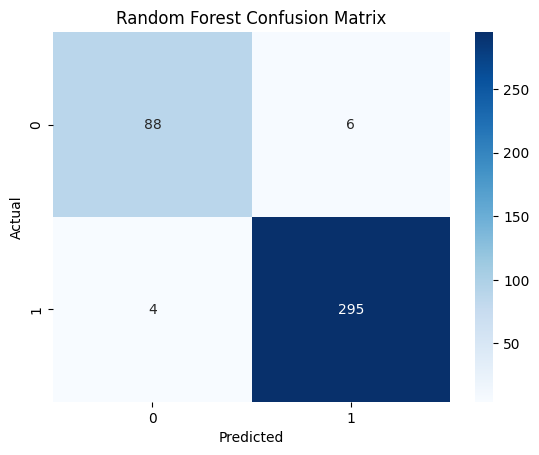

In [114]:
# 11. Confusion Matrix for Random Forest
sns.heatmap(confusion_matrix(y_test, rf.predict(X_test)), annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

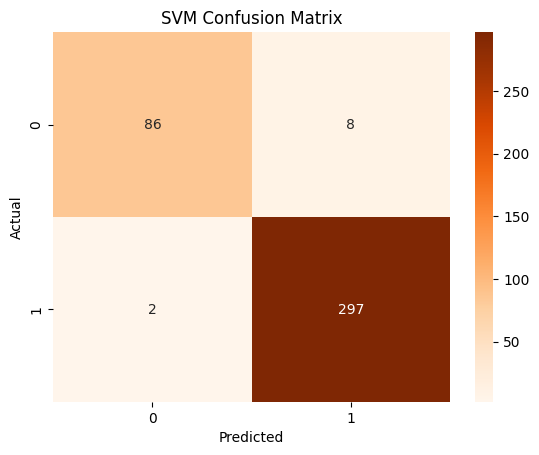

In [113]:
# 12. Confusion matrix for SVM
sns.heatmap(confusion_matrix(y_test, svm.predict(X_test)), annot=True, fmt='d', cmap='Oranges')
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [106]:

# 13. PCA Visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)

In [107]:
# Create a DataFrame for easy visualization
pca_df = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])
pca_df['ER_STATUS'] = y  # Add clinical labels for color coding


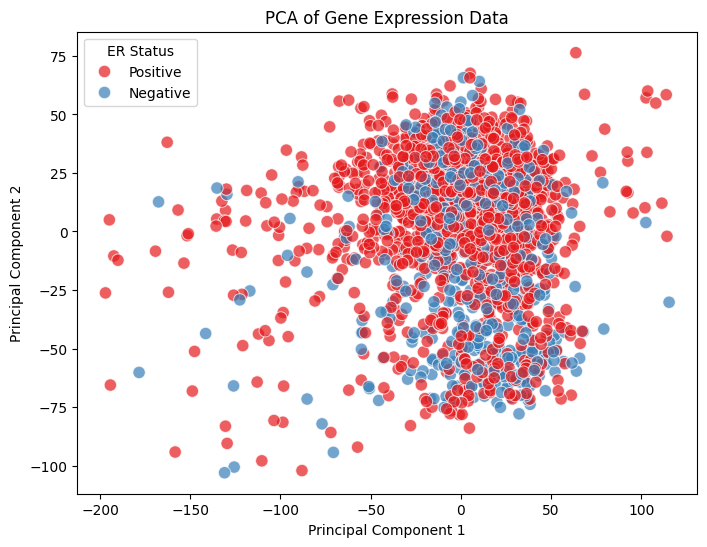

In [108]:
# Plotting PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='ER_STATUS', data=pca_df, palette='Set1', s=80, alpha=0.7)
plt.title('PCA of Gene Expression Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='ER Status')
plt.show()

ROC AUC (Random Forest): 0.9979363836903152


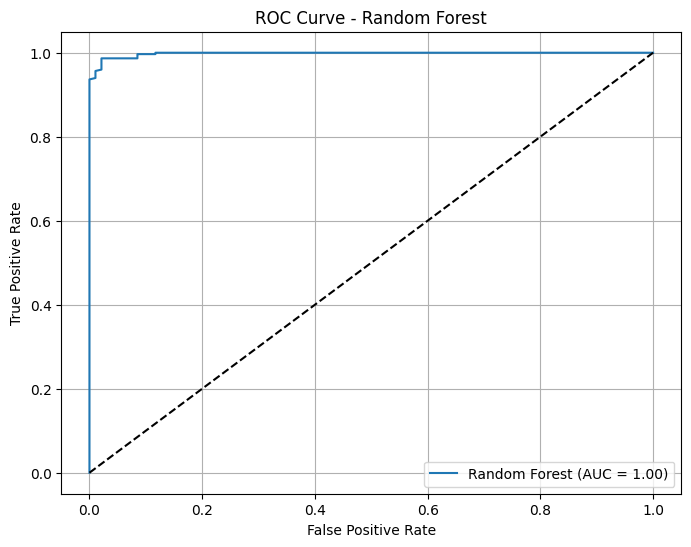

In [123]:
# 14. ROC AUC and Curve for Random Forest
y_probs_rf = rf.predict_proba(X_test)
roc_auc_rf = roc_auc_score(y_test, y_probs_rf[:, 1])
print("ROC AUC (Random Forest):", roc_auc_rf)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_probs_rf[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

ROC AUC (SVM): 0.9975094285917598


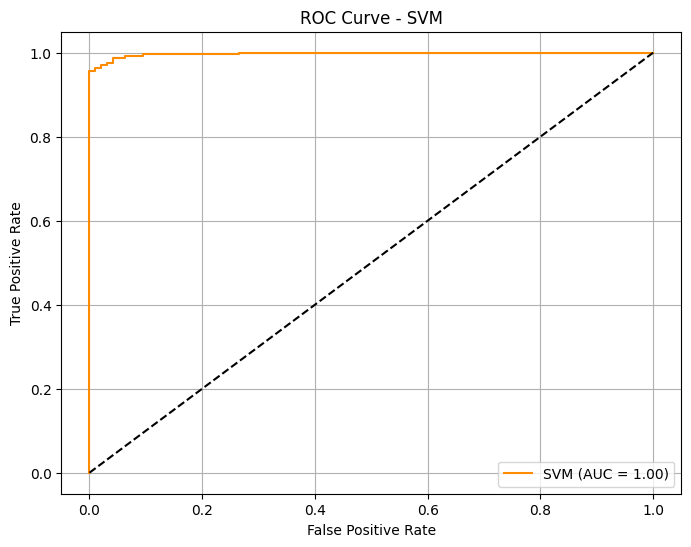

In [124]:
# 15. ROC Curve (SVM)
y_probs_svm = svm.predict_proba(X_test)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_probs_svm[:, 1])
roc_auc_svm = roc_auc_score(y_test, y_probs_svm[:, 1])
print("ROC AUC (SVM):", roc_auc_svm)
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {roc_auc_svm:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()